In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../codes/')
import prob_g3groupfinder as pg3
from smoothedbootstrap import smoothedbootstrap as sbs
from robustats import weighted_median
import foftools as fof
import iterativecombination as ic
from copy import deepcopy
from scipy.optimize import curve_fit

from astropy.cosmology import LambdaCDM
cosmo=LambdaCDM(70.,0.3,0.7)

In [2]:
eco = pd.read_csv("/srv/one/zhutchen/g3groupfinder/resolve_and_eco/ECOdata_G3catalog_luminosity.csv").set_index('name')
eco.loc[:,'czerr'] = eco.cz*0 + 35
ecophotz = pd.read_csv("/srv/one/hperk4/eco_resb_decals_photoz.csv")
ecophotz = ecophotz[ecophotz.name.str.startswith('ECO')].set_index('name')
eco = pd.concat([eco,ecophotz],axis=1)
eco.loc[:,'photo_z_corr'] = eco.photo_z_corr.fillna(value=eco.cz)
eco.loc[:,'e_tab_corr'] = eco.e_tab_corr.fillna(value=eco.czerr)

In [3]:
ecophotz

,spec_z,photo_z,photo_z_corr,e_tab,e_tab_corr
name,,,,,
ECO13218,4995.380486,5353.5,4291.486524,4690.2,3715.760211
ECO02822,6805.777192,7600.8,6703.018575,1814.4,1433.800051
ECO00207,3665.057389,3835.2,2978.639301,1504.8,1188.386247
ECO11747,6772.449470,7311.3,6815.529131,920.4,722.812845
ECO02809,6865.686588,8078.7,7154.884432,9285.6,7340.746142
...,...,...,...,...,...
ECO02650,6245.210387,4344.6,3443.347356,1798.2,1421.074487
ECO11696,3526.419545,2696.7,2144.955723,1541.7,1211.788829
ECO10811,7408.910632,5644.5,4585.306889,2561.4,2029.153226


In [4]:
eco = eco[(eco.absrmag<=-19.5)]

In [5]:
degradedcz = deepcopy(eco.cz.to_numpy())
zphot = deepcopy(eco.photo_z_corr.to_numpy())
zphoterr = deepcopy(eco.e_tab_corr.to_numpy())
degradedczerr = np.zeros_like(degradedcz)+35

idx = np.random.choice(np.indices(degradedcz.shape)[0], size=int(0.85*len(degradedcz)), replace=False) # originally 0.85
degradedcz[idx] = zphot[idx]
degradedczerr[idx] = zphoterr[idx]


sel = np.isnan(degradedcz)
degradedcz[sel] = eco.cz.to_numpy()[sel]
degradedczerr[sel] = 35

eco.loc[:,'degradedcz'] = degradedcz
eco.loc[:,'degradedczerr'] = degradedczerr

# PFoF groups using spec-z's

In [6]:
bperp = 0.07
blos = 1.1
s = (1.91936e5/len(eco))**(1/3.)
Pth = 0.1

In [7]:
eco.loc[:,'pfofid_hq'] = pg3.pfof_comoving(eco.radeg, eco.dedeg, eco.cz, eco.czerr, bperp*s, blos*s, Pth)

grpra, grpdec, grpz, zpdfs_hq = pg3.prob_group_skycoords(eco.radeg.to_numpy(), eco.dedeg.to_numpy(), eco.cz.to_numpy()/3e5, eco.czerr.to_numpy()/3e5, eco.pfofid_hq.to_numpy(), True)
grpn = fof.multiplicity_function(eco.pfofid_hq, return_by_galaxy=True)
eco.loc[:,'pfofgrpn_hq'] = grpn
eco.loc[:,'pfofgrpra_hq'] = grpra
eco.loc[:,'pfofgrpdec_hq'] = grpdec
eco.loc[:,'pfofgrpz_hq'] = grpz

PFoF complete!


# PFoF groups using photo-z's (low quality)

In [8]:
eco.loc[:,'pfofid_lq'] = pg3.pfof_comoving(eco.radeg, eco.dedeg, eco.degradedcz, eco.degradedczerr, bperp*s, blos*s, Pth)

grpra, grpdec, grpz, zpdfs_lq = pg3.prob_group_skycoords(eco.radeg.to_numpy(), eco.dedeg.to_numpy(), eco.degradedcz.to_numpy()/3e5, eco.degradedczerr.to_numpy()/3e5, eco.pfofid_lq.to_numpy(), True)
grpn = fof.multiplicity_function(eco.pfofid_lq, return_by_galaxy=True)
eco.loc[:,'pfofgrpn_lq'] = grpn
eco.loc[:,'pfofgrpra_lq'] = grpra
eco.loc[:,'pfofgrpdec_lq'] = grpdec
eco.loc[:,'pfofgrpz_lq'] = grpz

PFoF complete!


# Compare

In [9]:
hqgroups = eco.groupby('pfofid_hq').first()
lqgroups = eco.groupby('pfofid_lq').first()

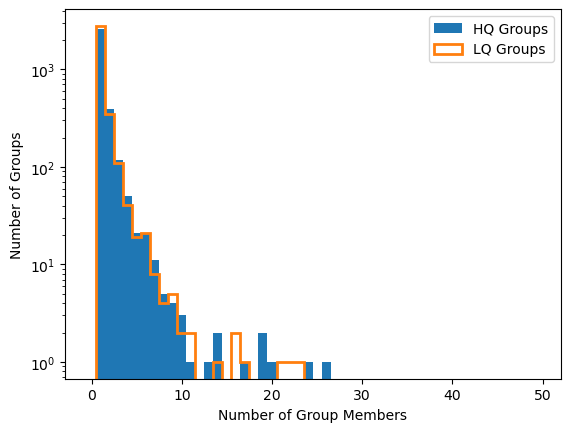

In [10]:
%matplotlib inline
plt.figure()
bins = np.arange(-0.5,50.5,1)
plt.hist(hqgroups.pfofgrpn_hq, bins=bins, label='HQ Groups')
plt.hist(lqgroups.pfofgrpn_lq, bins=bins, histtype='step', linewidth=2, label='LQ Groups')
plt.xlabel("Number of Group Members")
plt.ylabel("Number of Groups")
plt.yscale('log')
plt.legend(loc='best')
plt.show()

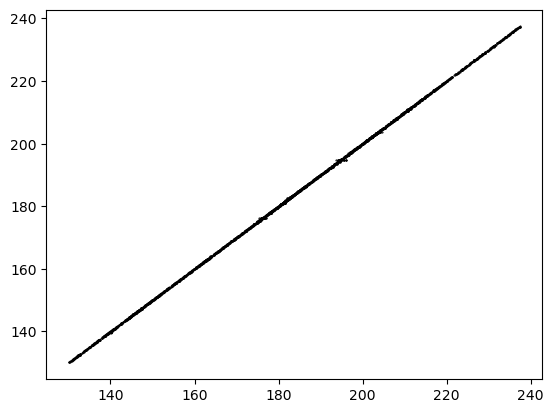

0.0


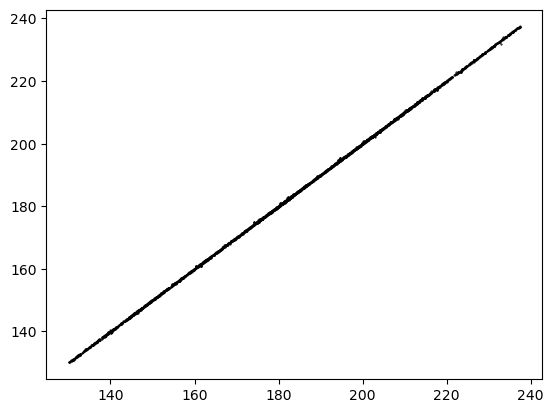

In [11]:
plt.figure()
plt.plot(eco.pfofgrpra_hq, eco.pfofgrpra_lq, 'k.',markersize=1)
plt.show()
print(np.median(np.abs(eco.pfofgrpra_hq-eco.pfofgrpra_lq)))

plt.figure()
plt.plot(eco.pfofgrpra_hq, eco.g3grpradeg_l, 'k.',markersize=1)
plt.show()

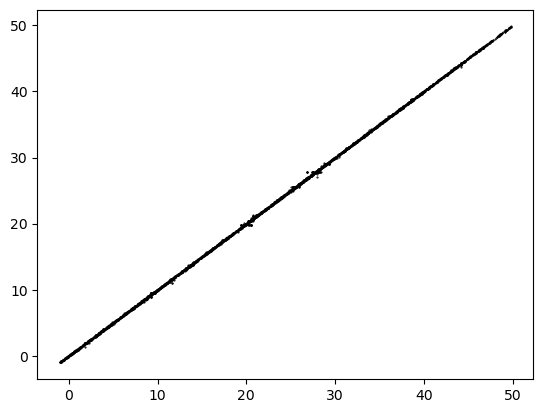

0.0


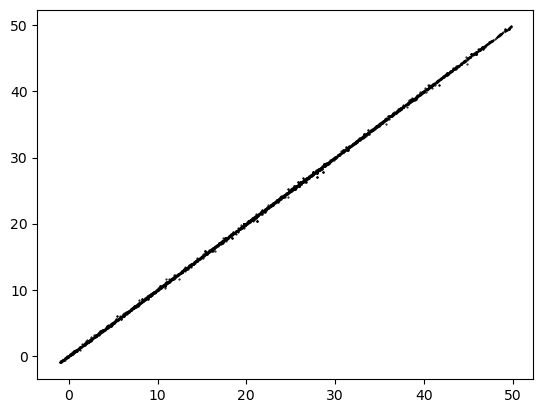

In [12]:
plt.figure()
plt.plot(eco.pfofgrpdec_hq, eco.pfofgrpdec_lq, 'k.',markersize=1)
plt.show()
print(np.median(np.abs(eco.pfofgrpdec_hq - eco.pfofgrpdec_lq)))

plt.figure()
plt.plot(eco.pfofgrpdec_hq, eco.g3grpdedeg_l, 'k.',markersize=1)
plt.show()

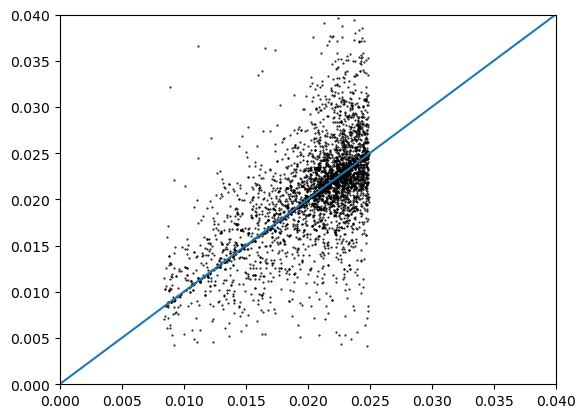

418.22009


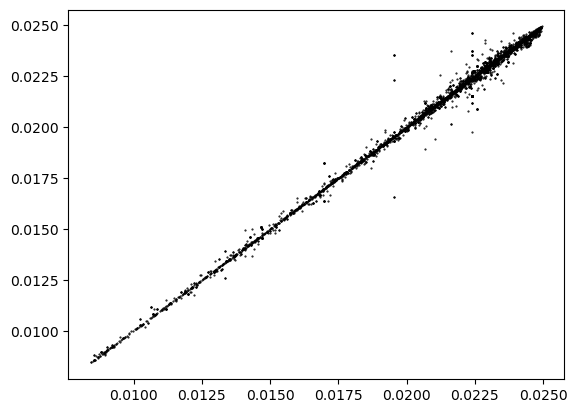

In [13]:
plt.figure()
plt.plot(eco.pfofgrpz_hq, eco.pfofgrpz_lq, 'k.',markersize=1)
plt.xlim(0,0.04)
plt.ylim(0,0.04)
tx = np.linspace(0,0.04)
plt.plot(tx,tx)
plt.show()
print('{:0.5f}'.format(np.median(np.abs(eco.pfofgrpz_hq*3e5 - eco.pfofgrpz_lq*3e5))))

plt.figure()
plt.plot(eco.pfofgrpz_hq, eco.g3grpcz_l/3e5, 'k.',markersize=1)
plt.show()

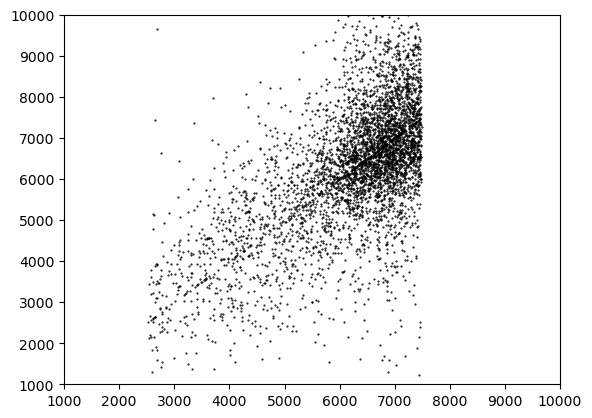

In [14]:
plt.figure()
plt.plot(eco.cz, eco.photo_z_corr, 'k.', markersize=1)
plt.xlim(1000,10000)
plt.ylim(1000,10000)
plt.show()

# Peculiar velocity dists

In [ ]:
SPEED_OF_LIGHT=3e5
relvel = np.abs(eco.cz - eco.pfofgrpz_hq*3e5)
grp_ctd = cosmo.comoving_transverse_distance(eco.pfofgrpz_hq.to_numpy()).value
gia_ctd = cosmo.comoving_transverse_distance(eco.cz/SPEED_OF_LIGHT).value
relprojdist = (grp_ctd+gia_ctd)*np.sin(ic.angular_separation(eco.pfofgrpra_hq, eco.pfofgrpdec_hq, eco.radeg, eco.dedeg)/2.0)
uniqgiantgrpn, uniqindex = np.unique(eco.pfofgrpn_hq.to_numpy(), return_index=True)
median_relprojdist = np.array([np.median(relprojdist[eco.pfofgrpn_hq==sz]) for sz in uniqgiantgrpn[1:]])
median_relvel = np.array([np.median(relvel[eco.pfofgrpn_hq==sz]) for sz in uniqgiantgrpn[1:]])

In [ ]:
fig,axs=plt.subplots(ncols=2)
axs[0].plot(uniqgiantgrpn[1:], median_relprojdist,'k.')
axs[1].plot(uniqgiantgrpn[1:], median_relvel,'k.')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,20)
axs[1].set_ylim(0,1000)
axs[1].set_xlim(0,20)
plt.show()

In [ ]:
median_relvel

In [ ]:
SPEED_OF_LIGHT=3e5
relvel = np.abs(eco.cz - eco.pfofgrpz_lq*3e5)
grp_ctd = cosmo.comoving_transverse_distance(eco.pfofgrpz_lq.to_numpy()).value
gia_ctd = cosmo.comoving_transverse_distance(eco.cz/SPEED_OF_LIGHT).value
relprojdist = (grp_ctd+gia_ctd)*np.sin(ic.angular_separation(eco.pfofgrpra_lq, eco.pfofgrpdec_lq, eco.radeg, eco.dedeg)/2.0)
uniqgiantgrpn, uniqindex = np.unique(eco.pfofgrpn_lq.to_numpy(), return_index=True)
#median_relprojdist = np.array([np.median(relprojdist[eco.pfofgrpn_lq==sz]) for sz in uniqgiantgrpn[1:]])
#median_relvel = np.array([np.median(relvel[eco.pfofgrpn_lq==sz]) for sz in uniqgiantgrpn[1:]])
mean_relprojdist = np.array([np.average(relprojdist[eco.pfofgrpn_lq==sz], weights=1/eco[eco.pfofgrpn_lq==sz].degradedczerr) for sz in uniqgiantgrpn[1:]])
mean_relvel = np.array([np.average(relvel[eco.pfofgrpn_lq==sz], weights=1/eco[eco.pfofgrpn_lq==sz].degradedczerr) for sz in uniqgiantgrpn[1:]])

In [ ]:
fig,axs=plt.subplots(ncols=2)
model = lambda x, av, bv: av*np.log10(bv*x + 1)

axs[0].plot(uniqgiantgrpn[1:], mean_relprojdist,'k.')
popt,pcov = curve_fit(model,uniqgiantgrpn[1:],mean_relprojdist)
tx = np.linspace(0,20)
axs[0].plot(tx, model(tx,*popt))

axs[1].plot(uniqgiantgrpn[1:], mean_relvel,'k.')
axs[1].plot(uniqgiantgrpn[1:], mean_relvel,'k.')
popt,pcov = curve_fit(model,uniqgiantgrpn[1:],mean_relvel)
tx = np.linspace(0,20)
axs[1].plot(tx, model(tx,*popt))


axs[0].set_ylim(0,1)
axs[0].set_xlim(0,20)
axs[1].set_ylim(0,1000)
axs[1].set_xlim(0,20)
plt.show()

# Make paper fig

In [ ]:
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib.colors import LogNorm
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Helvetica']
#rcParams['text.usetex'] = True
rcParams['grid.color'] = 'k'
rcParams['grid.linewidth'] = 0.2
my_locator = MaxNLocator(6)
singlecolsize = (3.3522420091324205, 2.0717995001590714)
doublecolsize = (7.100005949910059, 4.3880449973709)

In [ ]:
%matplotlib inline

In [ ]:
def giantmodel(x, a, b):
    return np.abs(a)*np.log10(np.abs(b)*x+1)

def g3groupfinder_luminosity(radeg,dedeg,cz,czerr,absrmag,dwarfgiantdivide,fof_bperp=0.07,fof_blos=1.1,fof_sep=None, volume=None,pfof_Pth=0.01, center_mode='average',\
                 iterative_giant_only_groups=False, n_bootstraps=10000, rproj_fit_guess=None, rproj_fit_params = None, rproj_fit_multiplier=None,\
                 vproj_fit_guess = None, vproj_fit_params = None, vproj_fit_multiplier=None, vproj_fit_offset=0, gd_rproj_fit_guess=None, gd_rproj_fit_params = None,\
                 gd_rproj_fit_multiplier=None, gd_vproj_fit_guess=None, gd_vproj_fit_params = None, gd_vproj_fit_multiplier=None,gd_vproj_fit_offset=None,
                 gd_fit_bins=None,ic_center_mode='arithmetic', ic_decision_mode='centers',H0=100., Om0=0.3, Ode0=0.7, showplots=False, saveplotspdf=False):
    radeg=np.array(radeg)
    dedeg=np.array(dedeg)
    cz=np.array(cz)
    czerr=np.array(czerr)
    absrmag=np.array(absrmag)
    g3grpid = np.zeros_like(radeg)-99.
    g3ssid = np.zeros_like(radeg)-99.
    cosmo = LambdaCDM(H0=H0,Om0=Om0,Ode0=Ode0)
    SPEED_OF_LIGHT=2.998e+5
    ### giant-only FoF ----------------- # 
    giantsel = (absrmag<=dwarfgiantdivide)
    if fof_sep is not None:
        giantfofid = pg3.pfof_comoving(radeg[giantsel], dedeg[giantsel], cz[giantsel], czerr[giantsel], fof_bperp*fof_sep, fof_blos*fof_sep, pfof_Pth, H0=H0, Om0=Om0, Ode0=Ode0)
    else:
        fof_sep = (volume/np.sum(giantsel))**(1/3.)
        giantfofid = pg3.pfof_comoving(radeg[giantsel], dedeg[giantsel], cz[giantsel], czerr[giantsel], fof_bperp*fof_sep, fof_blos*fof_sep, pfof_Pth, H0=H0, Om0=Om0, Ode0=Ode0)
    g3grpid[giantsel] = giantfofid

    ### if values not passed, fit rproj and vproj vs. N_giants
    if (rproj_fit_params is None) or (vproj_fit_params is None):
        if center_mode=='average' or center_mode=='giantaverage':
            #giantgrpra, giantgrpdec, giantgrpcz = fof.group_skycoords(radeg[giantsel], dedeg[giantsel], cz[giantsel], giantfofid)
            giantgrpra, giantgrpdec, giantgrpz, zpdfs = pg3.prob_group_skycoords(radeg[giantsel], dedeg[giantsel], cz[giantsel]/3e5, czerr[giantsel]/3e5, giantfofid)
            giantgrpcz = giantgrpz * 3e5
        else:
            raise ValueError('check group center definition (`center_mode`), only `average` or `giantaverage` (equivalent) currently supported')
        relvel = np.abs(giantgrpcz - cz[giantsel])/(1+giantgrpz) # from https://academic.oup.com/mnras/article/442/2/1117/983284#30931438
        grp_ctd = cosmo.comoving_transverse_distance(giantgrpz).value
        #gia_ctd = cosmo.comoving_transverse_distance(cz[giantsel]/SPEED_OF_LIGHT).value
        relprojdist = (grp_ctd+grp_ctd)*np.sin(ic.angular_separation(giantgrpra, giantgrpdec, radeg[giantsel], dedeg[giantsel])/2.0)
        giantgrpn = fof.multiplicity_function(giantfofid, return_by_galaxy=True)
        uniqgiantgrpn, uniqindex = np.unique(giantgrpn, return_index=True)
        keepcalsel = np.where(uniqgiantgrpn>1)
        #wavg_relprojdist = np.array([np.average(relprojdist[np.where(giantgrpn==sz)], weights=1/czerr[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        #wavg_relvel = np.array([np.average(relvel[np.where(giantgrpn==sz)], weights=1/czerr[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        wavg_relprojdist = np.array([weighted_median(relprojdist[np.where(giantgrpn==sz)], 1/czerr[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        wavg_relvel = np.array([weighted_median(relvel[np.where(giantgrpn==sz)], 1/czerr[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        wavg_relprojdist_err = np.zeros_like(wavg_relprojdist)
        wavg_relvel_err = np.zeros_like(wavg_relvel)
        
        
        for ii,nn in enumerate(uniqgiantgrpn[keepcalsel]):
            df_ = pd.DataFrame({'czerr':czerr[np.where(giantgrpn==nn)], 'rpdist':relprojdist[np.where(giantgrpn==nn)], 'dv':relvel[np.where(giantgrpn==nn)]})
            resamples = [df_.sample(frac=1, replace=True) for ii in range(0,n_bootstraps)]
            # wavg_relprojdist_err[ii] = np.std([np.average(resamp.rpdist, weights=1/resamp.czerr) for resamp in resamples])
            # wavg_relvel_err[ii] = np.std([np.average(resamp.dv, weights=1/resamp.czerr) for resamp in resamples])
            wavg_relprojdist_err[ii] = np.std([weighted_median(resamp.rpdist, 1/resamp.czerr) for resamp in resamples])
            wavg_relvel_err[ii] = np.std([weighted_median(resamp.dv, 1/resamp.czerr) for resamp in resamples])
        ###### fix below! need weighted averages not medians and some other error estimate...
        #median_relprojdist = np.array([np.median(relprojdist[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        #median_relvel = np.array([np.median(relvel[np.where(giantgrpn==sz)]) for sz in uniqgiantgrpn[keepcalsel]])
        #rproj_median_error = np.std(np.array([sbs(relprojdist[np.where(giantgrpn==sz)], n_bootstraps, np.median, kwargs=dict({'axis':1 })) for sz in uniqgiantgrpn[keepcalsel]]), axis=1)
        #dvproj_median_error = np.std(np.array([sbs(relvel[np.where(giantgrpn==sz)], n_bootstraps, np.median, kwargs=dict({'axis':1})) for sz in uniqgiantgrpn[keepcalsel]]), axis=1)
    if rproj_fit_params is None:
        rproj_bestfit, rproj_bestfit_cov = curve_fit(giantmodel, uniqgiantgrpn[keepcalsel], wavg_relprojdist)#, sigma=wavg_relprojdist_err, p0=rproj_fit_guess)
        rproj_bestfit_err = np.sqrt(np.diag(rproj_bestfit_cov))
    else:
        rproj_bestfit = np.array(rproj_fit_params)
        rproj_bestfit_err = np.zeros(2)*1.
    if vproj_fit_params is None:
        vproj_bestfit, vproj_bestfit_cov  = curve_fit(giantmodel, uniqgiantgrpn[keepcalsel], wavg_relvel)#, sigma=wavg_relvel_err, p0=vproj_fit_guess)
        vproj_bestfit_err = np.sqrt(np.diag(vproj_bestfit_cov))
    else:
        vproj_bestfit = np.array(vproj_fit_params)
        vproj_bestfit_err = np.zeros(2)*1.

    rproj_boundary = lambda Ngiants: rproj_fit_multiplier*giantmodel(Ngiants, *rproj_bestfit)
    vproj_boundary = lambda Ngiants: vproj_fit_multiplier*giantmodel(Ngiants, *vproj_bestfit) + vproj_fit_offset
    
    fig,axs=plt.subplots(figsize=doublecolsize, ncols=2)
    tx = np.linspace(1,30,500)
    sel = np.where(giantgrpn>1)
    axs[0].plot(giantgrpn[sel], relprojdist[sel], 'r.', markersize=2, alpha=0.5, label='ECO Giant Galaxies',zorder=0, rasterized=True)
    axs[0].errorbar(uniqgiantgrpn[keepcalsel], wavg_relprojdist, wavg_relprojdist_err, fmt='^', color='k', label=r'$R_{\rm proj}$',zorder=0)
    axs[0].plot(tx, giantmodel(tx,*rproj_bestfit), color='blue', label=r'$1R_{\rm proj}^{\rm fit}$',zorder=2)
    axs[0].plot(tx, 3*giantmodel(tx,*rproj_bestfit), color='green', label=r'$3R_{\rm proj}^{\rm fit}$', linestyle='dashed',zorder=3)
    axs[0].plot(tx, giantmodel(tx,*(3.06e-1,4.16e-1)), color='gray', label=r'$1R_{\rm proj}^{\rm fit}$ from H23',zorder=2)
    print(giantmodel(20,*(3.06e-1,4.16e-1)))
    
    axs[1].plot(giantgrpn[sel], relvel[sel], 'r.', markersize=2, alpha=0.5, label='ECO Giant Galaxies',zorder=0, rasterized=True)
    axs[1].errorbar(uniqgiantgrpn[keepcalsel], wavg_relvel, wavg_relvel_err, fmt='^', color='k', label=r'$\Delta v_{\rm proj}$',zorder=0)
    axs[1].plot(tx, giantmodel(tx,*vproj_bestfit), color='blue', label=r'$1\Delta v_{\rm proj}^{\rm fit}$',zorder=2)
    axs[1].plot(tx, 4*giantmodel(tx,*vproj_bestfit)+200, color='green', label=r'$4\Delta v_{\rm proj}^{\rm fit} + 200$ km s$^{-1}$',zorder=3, linestyle='dashed')
    axs[1].plot(tx, giantmodel(tx,*(3.45e2,0.17)), color='gray', label=r'$1\Delta v_{\rm proj}^{\rm fit}$ from H23',zorder=3)

    print('rproj diff N=20', giantmodel(20,*rproj_bestfit) - giantmodel(20,*(3.06e-1,4.16e-1)))
    print('vproj diff N=2', giantmodel(2,*vproj_bestfit) - giantmodel(2,*(3.45e2,0.17)))
    print('vproj diff N=20', giantmodel(20,*vproj_bestfit) - giantmodel(20,*(3.45e2,0.17)))
    
    for ii in range(0,2):
        axs[ii].set_xlim(0,20)
        axs[ii].set_xlabel("Number of Giant Members in Initial Group")
        axs[ii].legend(loc='upper right',fontsize=8)
        tks = np.arange(0,22,2)
        axs[ii].set_xticks(tks)
    axs[0].set_ylabel("Projected Distance from Giant to Group Center [Mpc]")
    axs[1].set_ylabel(r"Relative Velocity from Giant to Group Center [km s$^{-1}$]")
    axs[0].set_ylim(0,1.0)
    axs[1].set_ylim(0,1000)
    plt.tight_layout()
    plt.savefig("../figures/rproj_vproj_cal.pdf",dpi=300)
    plt.show()
    return g3grpid, uniqgiantgrpn[keepcalsel], wavg_relprojdist, wavg_relprojdist_err

In [ ]:
#g3groupfinder_luminosity(eco.radeg, eco.dedeg, eco.cz, eco.czerr, eco.absrmag, -19.5, fof_sep = ((1.91936e5/(0.7**3))/len(eco))**(1/3.), H0=70.)
_,xx,yy,yyerr=g3groupfinder_luminosity(eco.radeg, eco.dedeg, eco.degradedcz, eco.degradedczerr, eco.absrmag, -19.5, fof_sep = ((1.91936e5/(0.7**3))/len(eco))**(1/3.), pfof_Pth=0.01, H0=70.)

In [ ]:
# fig,axs=plt.subplots(figsize=doublecolsize, ncols=2)
# axs[0].errorbar(xx,yy,yyerr,fmt='o')
# #axs[0].set_xlim(0,20)
# axs[0].set_ylim(0,1)
# tx = np.linspace(0,100)
# popt,_=curve_fit(giantmodel, xx, yy, sigma=yyerr, absolute_sigma=True)
# axs[0].plot(tx,giantmodel(tx,*popt))
# plt.show()

# dwarf-only groups stat

In [ ]:
df = pd.read_csv("/srv/one/zhutchen/g3groupfinder/resolve_and_eco/ECOdata_G3catalog_luminosity.csv")

In [ ]:
df[(df.g3grpngi_l==0) & (df.g3grpndw_l>1) & (df.absrmag<=-17.33)].groupby('g3grp_l').first()[['g3grpngi_l','g3grpndw_l']]

In [ ]:
df[((df.g3grpngi_l+df.g3grpndw_l)>0) & (df.absrmag<=-17.33)].groupby('g3grp_l').first()[['g3grpngi_l','g3grpndw_l']]

In [ ]:
118/1200

In [ ]:
118/8967